In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd

In [109]:
data = pd.read_csv('data/importaciones_gasolina.csv')

# Seleccionando columnas de interes
columns = ['Fecha', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel alto azufre']
data = data[columns]

# Renombrando columnas
new_column_names = ['fecha', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre', 'gas_licuado_petroleo', 'gasolina_regular', 'gasolina_superior', 'diesel_alto_azufre']
data.columns = new_column_names

# Eliminando filas con valores nulos
data = data.dropna()

# Convirtiendo fecha a formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])

data


/var/folders/wd/kpmqk46j1wq467f_h9w8l5440000gn/T/ipykernel_11017/1056520668.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['fecha'] = pd.to_datetime(data['fecha'])


,fecha,diesel_bajo_azufre,diesel_ultra_bajo_azufre,gas_licuado_petroleo,gasolina_regular,gasolina_superior,diesel_alto_azufre
0,2001-01-01,0.00,0.00,"194,065.74","177,776.50","373,963.96","566,101.99"
1,2001-02-01,0.00,0.00,"170,703.38","123,115.99","243,091.07","489,525.80"
2,2001-03-01,0.00,0.00,"161,837.37","161,726.42","312,084.38","575,559.68"
3,2001-04-01,0.00,0.00,"163,048.64","127,338.74","285,054.89","437,745.42"
4,2001-05-01,0.00,0.00,"171,518.86","168,730.19","300,913.67","552,609.13"
...,...,...,...,...,...,...,...
264,2023-01-01,"1,442,099.08","45,074.97","497,780.69","909,391.13","578,792.14",0.00
265,2023-02-01,"1,267,967.39",0.00,"652,984.71","725,101.20","685,183.06",0.00
266,2023-03-01,"1,317,519.91","4,985.21","711,978.35","803,262.67","633,849.05",0.00
267,2023-04-01,"1,417,182.73","21,503.98","647,666.30","922,032.39","572,201.36",0.00


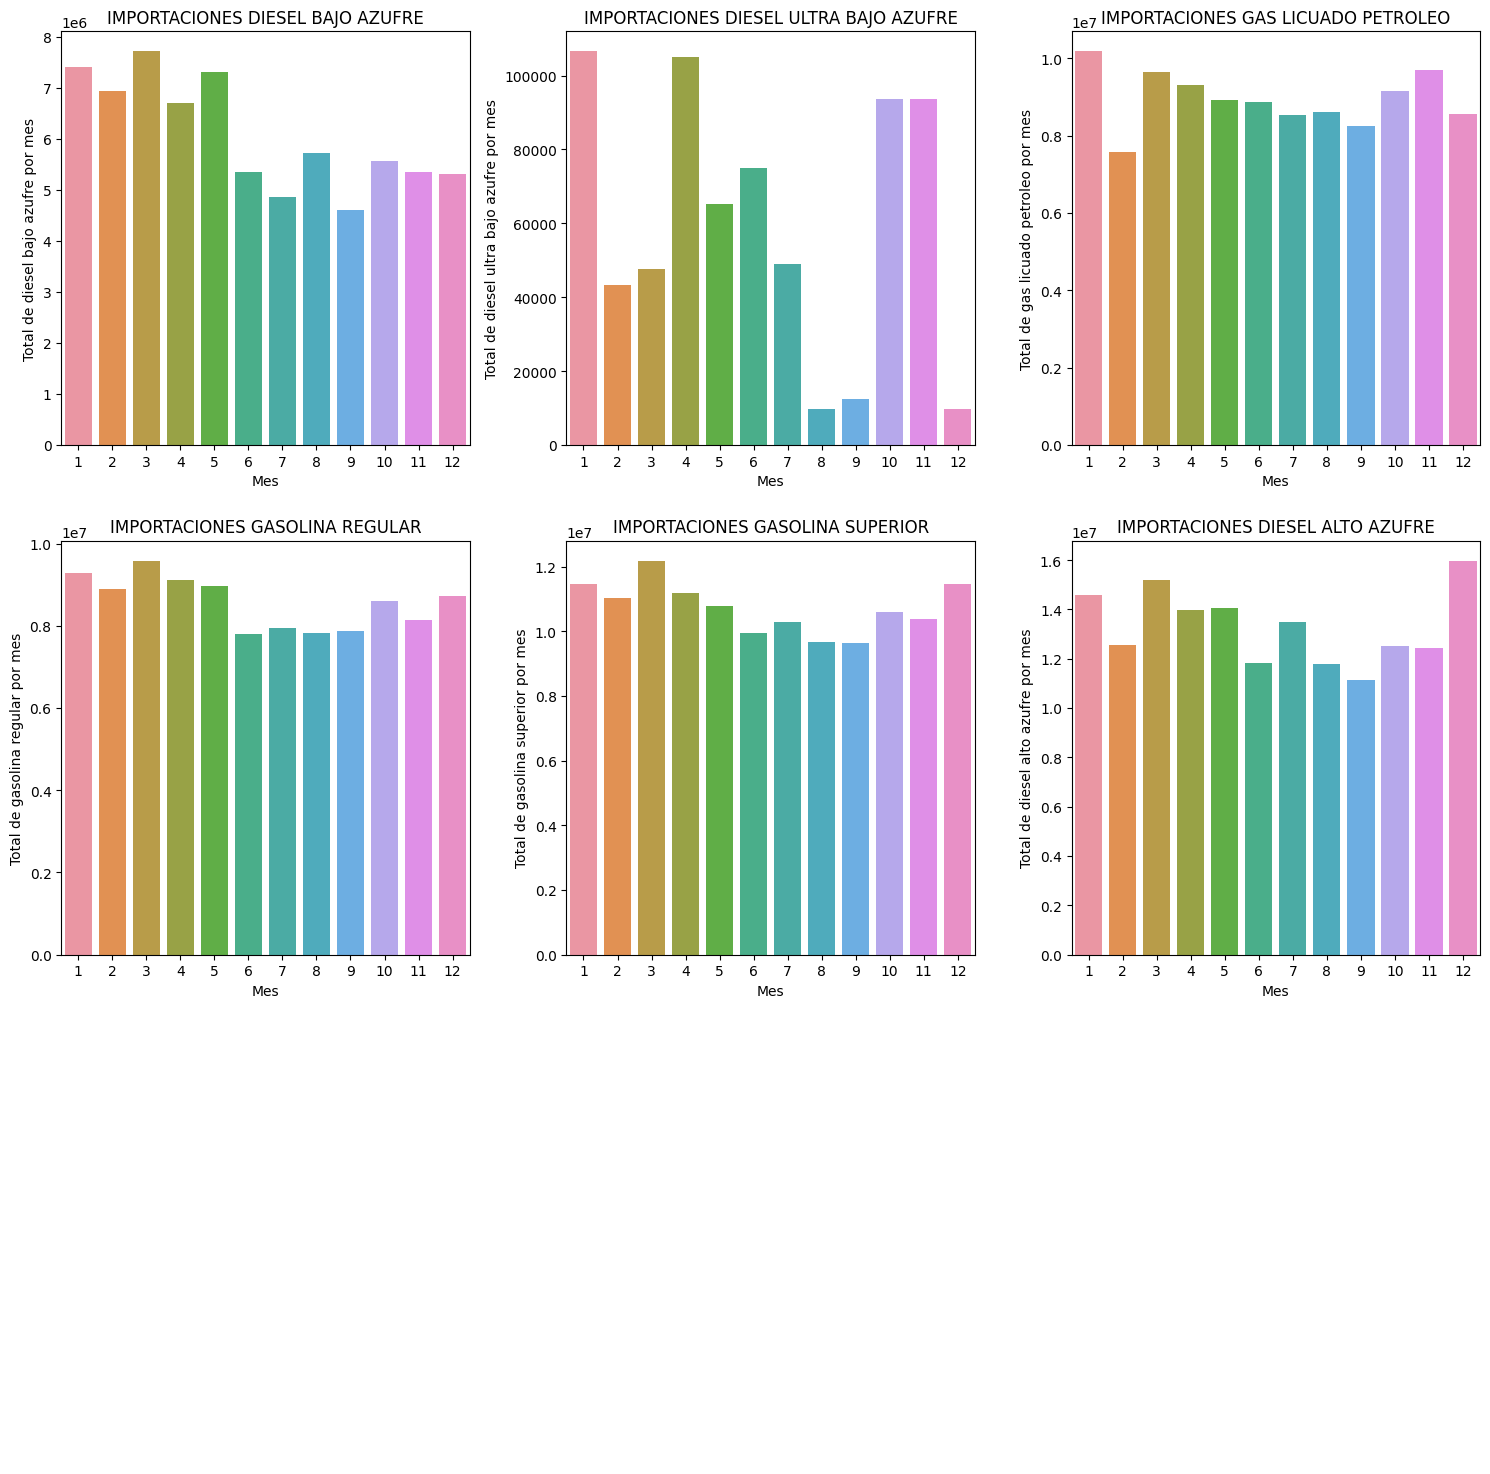

In [126]:
import seaborn as sns

data['mes'] = data['fecha'].dt.month
columns = [col for col in data.columns if col not in ['fecha', 'mes']]

frequency_rows = len(columns) // 3 + 1
frequency_cols = 3

fig, axs = plt.subplots(frequency_rows, frequency_cols, figsize=(15, 5 * frequency_rows))
axs = axs.flatten()

for ax, column in zip(axs, columns):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    monthly_values = data.groupby('mes')[column].sum()
    
    sns.barplot(x=monthly_values.index, y=monthly_values.values, ax=ax)
    ax.set_title(f"IMPORTACIONES {' '.join(column.split('_')).upper()}")
    ax.set_xlabel('Mes')
    ax.set_ylabel(f"Total de {' '.join(column.split('_'))} por mes")

for ax in axs[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
